In [1]:
from collections import Counter
import gc
import os

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from imutils.paths import list_images
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import *
import torch.optim as optim
import albumentations as A
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import hiplot as hip
import pandas as pd
import numpy as np
import torch
import timm
import cv2

In [2]:
BATCH_SIZE = 64
ROOT_PATH  = '/'.join(os.getcwd().split('/')[:-1])
DATA_PATH  = f'{ROOT_PATH}/TIL/dataset/Dacon'
EPOCHS     = 20
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LR         = 1e-3

device

device(type='cuda')

In [32]:
lb2idx = {lb  : idx for idx, lb in enumerate(os.listdir(f'{DATA_PATH}/train'))}
idx2lb = {idx : lb for lb, idx in lb2idx.items()} 
idx2lb

{0: '울음',
 1: '꼬임',
 2: '가구수정',
 3: '오타공',
 4: '걸레받이수정',
 5: '틈새과다',
 6: '들뜸',
 7: '오염',
 8: '몰딩수정',
 9: '면불량',
 10: '녹오염',
 11: '터짐',
 12: '피스',
 13: '훼손',
 14: '석고수정',
 15: '이음부불량',
 16: '곰팡이',
 17: '창틀,문틀수정',
 18: '반점'}

{'울음': 0,
 '꼬임': 1,
 '가구수정': 2,
 '오타공': 3,
 '걸레받이수정': 4,
 '틈새과다': 5,
 '들뜸': 6,
 '오염': 7,
 '몰딩수정': 8,
 '면불량': 9,
 '녹오염': 10,
 '터짐': 11,
 '피스': 12,
 '훼손': 13,
 '석고수정': 14,
 '이음부불량': 15,
 '곰팡이': 16,
 '창틀,문틀수정': 17,
 '반점': 18}

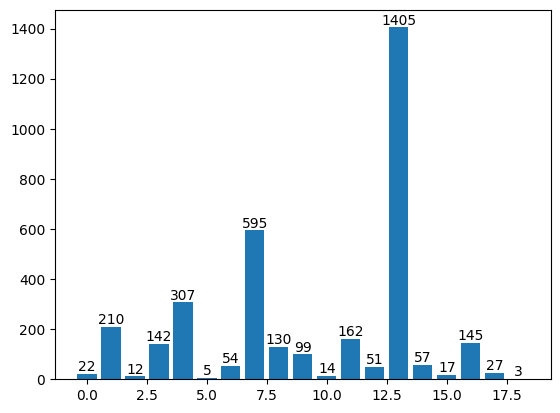

<Figure size 5000x2000 with 0 Axes>

In [4]:
image_paths = sorted(list_images(f'{DATA_PATH}/train/backup'))
labels      = [lb2idx[image_path.split('/')[-2]] for image_path in image_paths]

lb_cnt      = Counter(labels)
plt.bar(lb_cnt.keys(), lb_cnt.values())

for k, v in lb_cnt.items():
    
    plt.text(
            k, v, v,
            verticalalignment   = 'bottom',
            horizontalalignment = 'center'
        )

plt.figure(figsize = (50, 20))
lb2idx

(658, 629, 3)

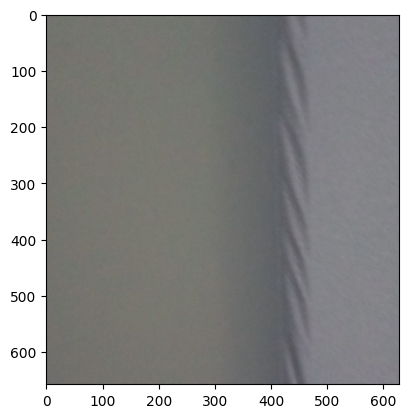

In [5]:
plt.imshow(cv2.imread(image_paths[0]))
cv2.imread(image_paths[0]).shape

In [6]:
train_x, test_x, train_y, test_y  = train_test_split(image_paths, labels, test_size = 0.2, 
                                                     stratify = labels, random_state = 99, shuffle = True)

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.2, 
                                                      stratify = train_y, random_state = 99, shuffle = True)

<Figure size 5000x2000 with 0 Axes>

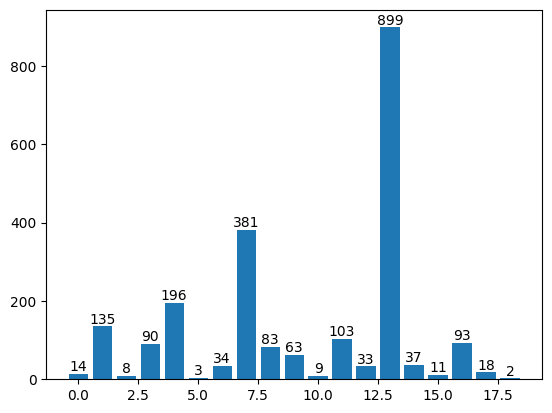

<Figure size 5000x2000 with 0 Axes>

In [7]:
lb_cnt      = Counter(train_y)
plt.bar(lb_cnt.keys(), lb_cnt.values())

for k, v in lb_cnt.items():
    
    plt.text(
            k, v, v,
            verticalalignment   = 'bottom',
            horizontalalignment = 'center'
        )

plt.figure(figsize = (50, 20))

<Figure size 5000x2000 with 0 Axes>

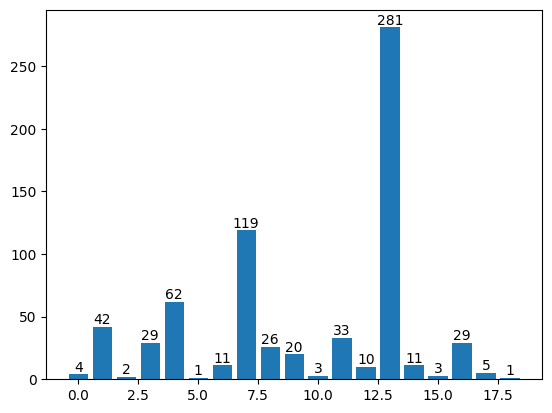

<Figure size 5000x2000 with 0 Axes>

In [8]:
lb_cnt      = Counter(test_y)
plt.bar(lb_cnt.keys(), lb_cnt.values())

for k, v in lb_cnt.items():
    
    plt.text(
            k, v, v,
            verticalalignment   = 'bottom',
            horizontalalignment = 'center'
        )

plt.figure(figsize = (50, 20))

In [9]:
class PaperingDataset(Dataset):
    
    def __init__(self, image_paths, labels, dtype = 'train'):
        
        self.image_paths = image_paths
        self.labels      = np.array(labels)
        self.dtype       = dtype
        
        self.transform   = {
                                'train' : transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.RandomResizedCrop(299),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomVerticalFlip(),
                                                transforms.ToTensor(),
                                            ]),
            
                                'valid' : transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((299, 299)),
                                        transforms.ToTensor()
                                ])
                            }
        
    
    def __len__(self):
        
        return self.labels.shape[0]
    
    
    def __getitem__(self, idx):
        
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform[self.dtype](image)
        
        return image, self.labels[idx]

(-0.5, 298.5, 298.5, -0.5)

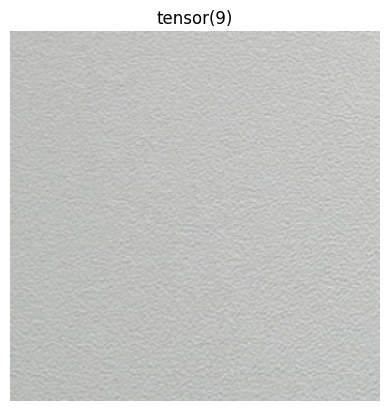

In [10]:
train_dataset         = PaperingDataset(train_x, train_y)
train_loader          = DataLoader(train_dataset, shuffle = True, batch_size = BATCH_SIZE)
sample_img, sample_lb = next(iter(train_loader))

plt.imshow(np.transpose(sample_img[0], (1, 2, 0)))
plt.title(sample_lb[0])
plt.axis(False)

(-0.5, 298.5, 298.5, -0.5)

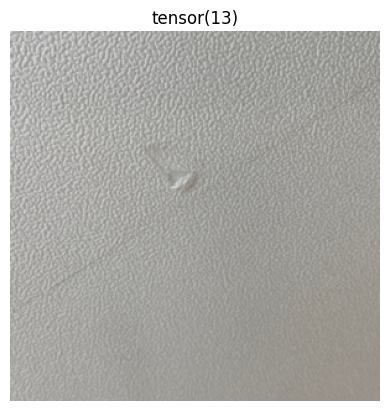

In [11]:
valid_dataset         = PaperingDataset(valid_x, valid_y, dtype = 'valid')
valid_loader          = DataLoader(valid_dataset, shuffle = False, batch_size = BATCH_SIZE)
sample_img, sample_lb = next(iter(valid_loader))

plt.imshow(np.transpose(sample_img[0], (1, 2, 0)))
plt.title(sample_lb[0])
plt.axis(False)

(-0.5, 298.5, 298.5, -0.5)

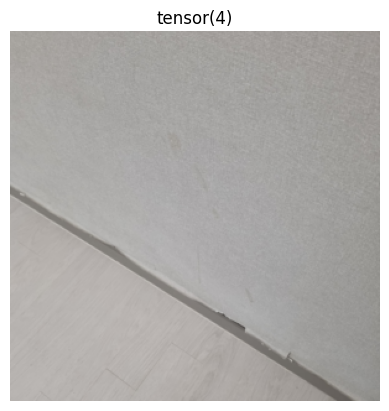

In [24]:
test_dataset          = PaperingDataset(test_x, test_y, dtype = 'valid')
test_loader           = DataLoader(test_dataset, shuffle = False, batch_size = 1)
sample_img, sample_lb = next(iter(test_loader))

plt.imshow(np.transpose(sample_img[0], (1, 2, 0)))
plt.title(sample_lb[0])
plt.axis(False)

In [13]:
class PaperingModel(nn.Module):
    
    def __init__(self, num_classes):
        
        super(PaperingModel, self).__init__()
        
        self.base_model = timm.create_model('inception_v4',
                                            pretrained = True, num_classes = num_classes)
        
    
    def forward(self, x):
        
        output = self.base_model(x)
        return output

In [14]:
criterion = nn.CrossEntropyLoss()
history = {
           'train' : {'accuracy' : [], 'loss' : [], 'f1' : []},
           'valid' : {'accuracy' : [], 'loss' : [], 'f1' : []}
          }

def get_optimizer(model):
    
    optimizer = optim.Adam(model.parameters(), lr = LR, weight_decay = 1e-3)
    optimizer.zero_grad()
    
    return optimizer


def train(model, train_loader, optimizer):
    
    model.train()
    total_loss, correct = 0, 0
    gt, predicted       = [], []
    
    for (images, labels) in tqdm(train_loader):
        images, labels = images.float().to(device), labels.to(device)
        
        outputs        = model(images)
        loss           = criterion(outputs, labels.data)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        _, preds    = torch.max(outputs, 1)
        
        predicted  += preds.detach().cpu().numpy().tolist()
        gt         += labels.detach().cpu().numpy().tolist()
        
        correct    += torch.sum(preds == labels)
        total_loss += loss
    
    avg_loss    = total_loss / len(train_loader)
    accuracy    = correct / (len(train_loader) * BATCH_SIZE)
    weighted_f1 = f1_score(gt, predicted, average = 'weighted')
    
    history['train']['loss'].append(avg_loss)
    history['train']['accuracy'].append(accuracy)
    history['train']['f1'].append(weighted_f1)
    
    print(f'[TRAIN] accuracy : {accuracy:.2f} | loss : {avg_loss:.2f} | weight f1 : {weighted_f1:.2f}')
    return accuracy


def validation(model, valid_loader):
    model.eval()
    total_loss, correct = 0, 0
    gt, predicted       = [], []
    
    with torch.no_grad():
        for (images, labels) in tqdm(valid_loader):
            images, labels = images.float().to(device), labels.to(device)

            outputs = model(images)
            loss    = criterion(outputs, labels)

            _, preds    = torch.max(outputs, 1)
            correct    += torch.sum(preds == labels.data)
            total_loss += loss.item()

            predicted  += preds.detach().cpu().numpy().tolist()
            gt         += labels.detach().cpu().numpy().tolist()

    avg_loss    = total_loss / len(valid_loader)
    accuracy    = correct / (len(valid_loader)*BATCH_SIZE)
    weighted_f1 = f1_score(gt, predicted, average = 'weighted')
    
    history['valid']['loss'].append(avg_loss.data)
    history['valid']['accuracy'].append(accuracy.data)
    history['valid']['f1'].append(weighted_f1)
    
    print(f'[VALID] accuracy : {accuracy:.2f} | loss : {avg_loss:.2f} | weight f1 : {weighted_f1:.2f}')
    return accuracy, outputs    

In [15]:
def run(model, train_loader, valid_loader):
  optimizer     = get_optimizer(model)

  early_stopping_counter = 0
  best_acc               = -1

  for epoch in range(EPOCHS):
    print(f'[{epoch + 1} / {EPOCHS}]')

    train_acc          = train(model, train_loader, optimizer)
    valid_acc, outputs = validation(model, valid_loader)

    if valid_acc > best_acc:
        os.makedirs('models/', exist_ok = True)
        
        best_acc               = valid_acc
        early_stopping_counter = 0
        
        torch.save(model, 'models/best_model.pt')
        print(f'save model with accuracy : {best_acc}')

    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 10:
            print(f'Training Stopped by Early stopping counter : {early_stopping_counter}')
            break


In [16]:
torch.cuda.empty_cache()
gc.collect()

model = PaperingModel(num_classes = len(labels))
model.to(device)

run(model, train_loader, valid_loader)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/inceptionv4-8e4777a0.pth" to /home/jovyan/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth


[1 / 20]


100%|██████████| 35/35 [00:43<00:00,  1.24s/it]


[TRAIN] accuracy : 0.47 | loss : 2.40 | weight f1 : 0.45


100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


[VALID] accuracy : 0.43 | loss : 5.43 | weight f1 : 0.41
save model with accuracy : 0.4340277910232544
[2 / 20]


100%|██████████| 35/35 [00:38<00:00,  1.09s/it]


[TRAIN] accuracy : 0.55 | loss : 1.49 | weight f1 : 0.52


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


[VALID] accuracy : 0.55 | loss : 1.50 | weight f1 : 0.54
save model with accuracy : 0.5451388955116272
[3 / 20]


100%|██████████| 35/35 [00:37<00:00,  1.06s/it]


[TRAIN] accuracy : 0.59 | loss : 1.38 | weight f1 : 0.56


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


[VALID] accuracy : 0.55 | loss : 1.87 | weight f1 : 0.54
save model with accuracy : 0.5486111044883728
[4 / 20]


100%|██████████| 35/35 [00:37<00:00,  1.07s/it]


[TRAIN] accuracy : 0.60 | loss : 1.34 | weight f1 : 0.57


100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


[VALID] accuracy : 0.57 | loss : 1.73 | weight f1 : 0.57
save model with accuracy : 0.5677083134651184
[5 / 20]


100%|██████████| 35/35 [00:37<00:00,  1.06s/it]


[TRAIN] accuracy : 0.62 | loss : 1.25 | weight f1 : 0.59


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


[VALID] accuracy : 0.53 | loss : 1.37 | weight f1 : 0.54
[6 / 20]


100%|██████████| 35/35 [00:37<00:00,  1.07s/it]


[TRAIN] accuracy : 0.61 | loss : 1.28 | weight f1 : 0.59


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


[VALID] accuracy : 0.58 | loss : 1.48 | weight f1 : 0.56
save model with accuracy : 0.5763888955116272
[7 / 20]


100%|██████████| 35/35 [00:37<00:00,  1.06s/it]


[TRAIN] accuracy : 0.64 | loss : 1.20 | weight f1 : 0.61


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


[VALID] accuracy : 0.61 | loss : 1.38 | weight f1 : 0.61
save model with accuracy : 0.6059027910232544
[8 / 20]


100%|██████████| 35/35 [00:37<00:00,  1.08s/it]


[TRAIN] accuracy : 0.64 | loss : 1.17 | weight f1 : 0.61


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


[VALID] accuracy : 0.61 | loss : 1.41 | weight f1 : 0.59
save model with accuracy : 0.6111111044883728
[9 / 20]


100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


[TRAIN] accuracy : 0.63 | loss : 1.21 | weight f1 : 0.60


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


[VALID] accuracy : 0.64 | loss : 1.19 | weight f1 : 0.62
save model with accuracy : 0.6354166865348816
[10 / 20]


100%|██████████| 35/35 [00:37<00:00,  1.06s/it]


[TRAIN] accuracy : 0.65 | loss : 1.17 | weight f1 : 0.63


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


[VALID] accuracy : 0.62 | loss : 1.19 | weight f1 : 0.61
[11 / 20]


100%|██████████| 35/35 [00:37<00:00,  1.07s/it]


[TRAIN] accuracy : 0.66 | loss : 1.12 | weight f1 : 0.64


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


[VALID] accuracy : 0.63 | loss : 1.22 | weight f1 : 0.64
[12 / 20]


100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


[TRAIN] accuracy : 0.64 | loss : 1.16 | weight f1 : 0.62


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


[VALID] accuracy : 0.59 | loss : 1.32 | weight f1 : 0.59
[13 / 20]


100%|██████████| 35/35 [00:37<00:00,  1.06s/it]


[TRAIN] accuracy : 0.64 | loss : 1.16 | weight f1 : 0.62


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


[VALID] accuracy : 0.62 | loss : 1.27 | weight f1 : 0.62
[14 / 20]


100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


[TRAIN] accuracy : 0.64 | loss : 1.15 | weight f1 : 0.61


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


[VALID] accuracy : 0.58 | loss : 1.33 | weight f1 : 0.57
[15 / 20]


100%|██████████| 35/35 [00:38<00:00,  1.10s/it]


[TRAIN] accuracy : 0.65 | loss : 1.15 | weight f1 : 0.62


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


[VALID] accuracy : 0.63 | loss : 1.19 | weight f1 : 0.62
[16 / 20]


100%|██████████| 35/35 [00:38<00:00,  1.09s/it]


[TRAIN] accuracy : 0.67 | loss : 1.09 | weight f1 : 0.65


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


[VALID] accuracy : 0.61 | loss : 1.24 | weight f1 : 0.59
[17 / 20]


100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


[TRAIN] accuracy : 0.68 | loss : 1.07 | weight f1 : 0.65


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


[VALID] accuracy : 0.66 | loss : 1.05 | weight f1 : 0.66
save model with accuracy : 0.6597222089767456
[18 / 20]


100%|██████████| 35/35 [00:37<00:00,  1.09s/it]


[TRAIN] accuracy : 0.66 | loss : 1.04 | weight f1 : 0.65


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


[VALID] accuracy : 0.57 | loss : 1.54 | weight f1 : 0.58
[19 / 20]


100%|██████████| 35/35 [00:38<00:00,  1.09s/it]


[TRAIN] accuracy : 0.68 | loss : 1.05 | weight f1 : 0.66


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


[VALID] accuracy : 0.67 | loss : 1.10 | weight f1 : 0.66
save model with accuracy : 0.6666666865348816
[20 / 20]


100%|██████████| 35/35 [00:37<00:00,  1.08s/it]


[TRAIN] accuracy : 0.67 | loss : 1.05 | weight f1 : 0.66


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]

[VALID] accuracy : 0.58 | loss : 1.32 | weight f1 : 0.59


In [17]:
history

{'train': {'accuracy': [tensor(0.4746, device='cuda:0'),
   tensor(0.5518, device='cuda:0'),
   tensor(0.5871, device='cuda:0'),
   tensor(0.6036, device='cuda:0'),
   tensor(0.6183, device='cuda:0'),
   tensor(0.6147, device='cuda:0'),
   tensor(0.6393, device='cuda:0'),
   tensor(0.6379, device='cuda:0'),
   tensor(0.6290, device='cuda:0'),
   tensor(0.6527, device='cuda:0'),
   tensor(0.6607, device='cuda:0'),
   tensor(0.6446, device='cuda:0'),
   tensor(0.6446, device='cuda:0'),
   tensor(0.6379, device='cuda:0'),
   tensor(0.6455, device='cuda:0'),
   tensor(0.6723, device='cuda:0'),
   tensor(0.6763, device='cuda:0'),
   tensor(0.6638, device='cuda:0'),
   tensor(0.6804, device='cuda:0'),
   tensor(0.6737, device='cuda:0')],
  'loss': [tensor(2.3984, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(1.4893, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(1.3849, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(1.3352, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(

In [22]:
def evaluation(model, test_loader):
    
    model.eval()
    
    total_loss, correct = 0, 0
    gt, predicted       = [], []
    
    with torch.no_grad():
        for (images, labels) in tqdm(test_loader):
            images, labels = images.float().to(device), labels.to(device)

            outputs = model(images)
            loss    = criterion(outputs, labels)

            _, preds    = torch.max(outputs, 1)
            correct    += torch.sum(preds == labels.data)
            total_loss += loss.item()

            predicted  += preds.detach().cpu().numpy().tolist()
            gt         += labels.detach().cpu().numpy().tolist()

    avg_loss    = total_loss / len(test_loader)
    accuracy    = correct / (len(test_loader)*BATCH_SIZE)
    weighted_f1 = f1_score(gt, predicted, average = 'weighted')

    print(f'[test] accuracy : {accuracy:.2f} | loss : {avg_loss:.2f} | weight f1 : {weighted_f1:.2f}')
    return classification_report(gt, predicted, target_names = lb2idx.keys())

In [25]:
report = evaluation(model, test_loader)
print(report)

100%|██████████| 692/692 [00:25<00:00, 27.33it/s]

[test] accuracy : 0.01 | loss : 1.26 | weight f1 : 0.62
              precision    recall  f1-score   support

          울음       0.00      0.00      0.00         4
          꼬임       0.87      0.48      0.62        42
        가구수정       0.00      0.00      0.00         2
         오타공       0.94      0.52      0.67        29
      걸레받이수정       0.76      0.73      0.74        62
        틈새과다       0.00      0.00      0.00         1
          들뜸       0.75      0.82      0.78        11
          오염       0.52      0.82      0.64       119
        몰딩수정       0.33      0.62      0.43        26
         면불량       1.00      0.05      0.10        20
         녹오염       0.00      0.00      0.00         3
          터짐       0.92      0.33      0.49        33
          피스       1.00      0.10      0.18        10
          훼손       0.79      0.73      0.76       281
        석고수정       0.00      0.00      0.00        11
       이음부불량       0.00      0.00      0.00         3
         곰팡이       0.28  


/opt/conda/envs/tensor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/tensor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/tensor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
submit_df  = pd.read_csv(f'{DATA_PATH}/test.csv')
test_paths = sorted([f'{DATA_PATH}/test/{image.split("_")[1]}.png' for image in submit_df['id']])
submit     = []

for test_path in tqdm(test_paths):
    
    transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((299, 299)),
                transforms.ToTensor()
            ])

    image = cv2.imread(test_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image).float().to(device)
    image = image.unsqueeze(0)

    outputs   = model(image)
    _, preds  = torch.max(outputs, 1)
    
    idx = preds.detach().cpu().numpy().tolist()[0]
    submit.append(idx2lb[idx])
    
submits          = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
submits['label'] = submit
submits.to_csv('submit.csv', index = False)

100%|██████████| 792/792 [00:32<00:00, 24.29it/s]
